In [1]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn.objects as so
import os
import io

import random

random.seed(42)

In [2]:
# set fixed order of elements in graphs
optimization_order = ['disabled', 'enabled']
service_mesh_order = ['none', 'cilium', 'istio-ambient', 'istio-sidecar']

In [3]:
def update_legend(g, mapping):
    for text in g.get_legend().get_texts():
        text.set(text=mapping[text.get_text()])

In [4]:
def count_decimal_places(num, remove_single_zero=False):
    str_num = str(num)
    if remove_single_zero and str_num.endswith('.0'):
        return 0
    if '.' in str_num:
        return len(str_num) - str_num.index('.') - 1
    else:
        return 0

In [5]:
def float_format(x, remove_single_zero=True):
    return '{:.{}f}'.format(x, min(count_decimal_places(x, remove_single_zero=remove_single_zero), pd.get_option('display.precision')))

In [6]:
def format_data_size(number, from_unit, to_unit, remove_single_decimal_zero=True):
    convert_table = {
        'B': 1,
        'K': 1000,
        'M': 1000 ** 2,
        'G': 1000 ** 3,
        'T': 1000 ** 4,
        'P': 1000 ** 5,
    }
    if from_unit[-1] == 'B' and to_unit[-1] == 'b':
        number *= 8
    if from_unit[-1] == 'b' and to_unit[-1] == 'B':
        number /= 8
    number *= convert_table[from_unit[0].upper()]
    number /= convert_table[to_unit[0].upper()]
    #return float_format(number, remove_single_decimal_zero)
    return number

In [7]:
def format_time(number, from_unit, to_unit, remove_single_decimal_zero=True):
    convert_table = {
        'ns': 1,
        'us': 10 ** 3,
        'ms': 10 ** 6,
         's': 10 ** 9,
    }
    number *= convert_table[from_unit]
    number /= convert_table[to_unit]
    #return float_format(number, remove_single_decimal_zero)
    return number

In [8]:
pd.set_option('display.precision', 1)
#pd.set_option('display.float_format', float_format)
pd.set_option('display.max_columns', None)

In [9]:
def print_latex(df):
    df = df.copy()
    df.index = pd.MultiIndex.from_tuples([(f'\\textit{{{a}}}' if a == 'none' else f'\\texttt{{{a}}}', b) for (a, b) in df.index], names=['Service Mesh', 'Mode'])
    print(df.to_latex(float_format=float_format))

In [10]:
import os
import re
import zipfile
from pprint import pprint


def logs_processing(basepath='.'):
    files = os.listdir(basepath)
    logs_zip_pattern = re.compile(r'logs_.*\.zip')
    logs_zip_files = [f for f in files if logs_zip_pattern.match(f)]

    workload_log_map = {
        'ping': 'ping-echo',
    }

    system_logs = []
    workload_logs = {}

    for zip_filename in logs_zip_files:
        zip_filename_components = zip_filename.split('.')[0].split('_')

        if len(zip_filename_components) != 4: continue

        _, cni, service_mesh, optimization = zip_filename_components

        with zipfile.ZipFile(os.path.join(basepath, zip_filename), 'r') as zip_ref:
            for file in zip_ref.infolist():
                if file.is_dir(): continue

                entry = { 'cni': cni, 'service_mesh': service_mesh, 'optimization': optimization, 'workload': None, 'data': None, 'meta': {} }

                filename = file.filename.replace(r'mnt/logs/', '')

                ###################
                ### system logs ###
                ###################

                ### statexec
                if filename.startswith('statexec_metrics'):
                    entry['workload'] = filename.split('_')[2]

                    if entry['workload'] not in workload_log_map.values(): continue

                    data = zip_ref.read(file).decode('utf-8')
                    statexec_pattern = re.compile(r'(?P<metric>.*){(?P<params>.*?)} (?P<value>.+) (?P<timestamp>\d+)')
                    statexec_param_pattern = re.compile(r',?(?P<k>.*?)="(?P<v>.*?)"')
                    data = [statexec_pattern.match(line).groupdict() for line in data.split('\n') if line != '' and line[0] != '#']
                    data = [{**value, 'params': { k: v for (k, v) in statexec_param_pattern.findall(value['params']) if k not in ['instance', 'job', 'role', 'cni', 'optimization', 'service_mesh'] } } for value in data ]
                    entry['data'] = data

                    system_logs.append(entry)
                    continue


                #####################
                ### workload logs ###
                #####################

                entry['workload'] = workload_log_map.get(filename.split('/')[0], None)

                if entry['workload'] == 'ping-echo':
                    data = zip_ref.read(file).decode('utf-8')
                    entry['data'] = data

                ### UNKNOWN
                else:
                    continue

                if entry['workload'] not in workload_logs:
                    workload_logs[entry['workload']] = []

                workload_logs[entry['workload']].append(entry)

    return { 'system_logs': system_logs, 'workload_logs': workload_logs }

In [11]:
logs = logs_processing('../workloads/')

# system-logs

In [12]:
system_logs = pd.DataFrame(logs['system_logs'])
del system_logs['meta']
system_logs = system_logs.explode('data').apply(lambda x: pd.concat([x.drop('data'), pd.json_normalize(x.data, sep='_').iloc[0]]), axis=1)
system_logs = system_logs.astype({'timestamp': 'int64', 'value': 'float64'}).sort_values(by='timestamp', ignore_index=True)
system_logs.drop_duplicates(inplace=True, ignore_index=True)

In [13]:
system_logs.head()

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload
0,calico,statexec_memory_cached_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354149117,2.6e+09,ping-echo
1,calico,statexec_memory_used_percent,disabled,NaN,NaN,NaN,NaN,none,1736354149117,1.6e+01,ping-echo
2,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,lo,NaN,none,1736354149117,3.1e+08,ping-echo
3,calico,statexec_network_received_bytes_total,disabled,NaN,NaN,lo,NaN,none,1736354149117,3.1e+08,ping-echo
4,calico,statexec_network_sent_bytes_total,disabled,NaN,NaN,cali91965474c08,NaN,none,1736354149117,3.4e+06,ping-echo


In [14]:
sorted(system_logs.metric.unique())

['statexec_command_status',
 'statexec_cpu_seconds_total',
 'statexec_disk_read_bytes_total',
 'statexec_disk_write_bytes_total',
 'statexec_memory_available_bytes',
 'statexec_memory_buffers_bytes',
 'statexec_memory_cached_bytes',
 'statexec_memory_free_bytes',
 'statexec_memory_total_bytes',
 'statexec_memory_used_bytes',
 'statexec_memory_used_percent',
 'statexec_metric_collect_duration_ms',
 'statexec_network_received_bytes_total',
 'statexec_network_sent_bytes_total',
 'statexec_statexec_time_since_start_ms',
 'statexec_summary_cpu_cores',
 'statexec_summary_cpu_mean_seconds',
 'statexec_summary_disk_mean_read_bytes_per_second',
 'statexec_summary_disk_mean_write_bytes_per_second',
 'statexec_summary_memory_buffers_bytes',
 'statexec_summary_memory_cached_bytes',
 'statexec_summary_memory_free_bytes',
 'statexec_summary_memory_total_bytes',
 'statexec_summary_memory_used_bytes',
 'statexec_summary_network_mean_received_bytes_per_second',
 'statexec_summary_network_mean_sent_byte

In [15]:
sorted(system_logs[system_logs.metric.eq('statexec_cpu_seconds_total')].params_mode.unique())

['guest',
 'guestNice',
 'idle',
 'iowait',
 'irq',
 'nice',
 'softirq',
 'steal',
 'system',
 'user']

In [16]:
system_logs.timestamp.diff().abs().sort_values(ascending=False)[:25]

81536    936039.0
14888    817911.0
62256    711158.0
43676    657175.0
8774     501725.0
74166    493310.0
90608    491172.0
766        1000.0
71066      1000.0
49564      1000.0
52732      1000.0
70168      1000.0
53788      1000.0
79468      1000.0
67558      1000.0
41808      1000.0
83958      1000.0
23240      1000.0
76498      1000.0
8942       1000.0
29488      1000.0
67198      1000.0
77038      1000.0
81978      1000.0
26320      1000.0
Name: timestamp, dtype: float64

In [17]:
system_logs['x'] = (system_logs.timestamp.diff().abs().gt(40_000).cumsum() + 1).astype(str)
start_point = system_logs.groupby('x')['timestamp'].transform(lambda x: x.min())
system_logs['elapsed'] = system_logs.timestamp - start_point

In [18]:
cpu_seconds_cum = system_logs[
    (system_logs['metric'] == 'statexec_cpu_seconds_total') &
    (system_logs['params_mode'].isin(['user', 'system']))
].groupby(['workload', 'service_mesh', 'optimization', 'timestamp', 'elapsed'])['value'].sum().reset_index()

cpu_seconds_cum

,workload,service_mesh,optimization,timestamp,elapsed,value
0,ping-echo,cilium,disabled,1736359175435,0,329.6
1,ping-echo,cilium,disabled,1736359175445,10,329.7
2,ping-echo,cilium,disabled,1736359176435,1000,332.0
3,ping-echo,cilium,disabled,1736359177435,2000,332.3
4,ping-echo,cilium,disabled,1736359178435,3000,333.4
...,...,...,...,...,...,...
1094,ping-echo,none,enabled,1736354815842,66000,1509.7
1095,ping-echo,none,enabled,1736354816735,66893,1510.3
1096,ping-echo,none,enabled,1736354816842,67000,1510.3
1097,ping-echo,none,enabled,1736354817842,68000,1510.9


In [19]:
cpu_seconds_usage = cpu_seconds_cum.groupby(['workload', 'service_mesh', 'optimization'])['value'].agg(
    value=lambda x: np.ptp(x),
).reset_index()

cpu_seconds_usage

,workload,service_mesh,optimization,value
0,ping-echo,cilium,disabled,104.9
1,ping-echo,cilium,enabled,92.3
2,ping-echo,istio-ambient,disabled,132.2
3,ping-echo,istio-ambient,enabled,103.2
4,ping-echo,istio-sidecar,disabled,357.8
5,ping-echo,istio-sidecar,enabled,274.7
6,ping-echo,none,disabled,110.5
7,ping-echo,none,enabled,92.6


In [20]:
memory_used_bytes = system_logs[system_logs.metric.eq('statexec_memory_used_bytes')]
memory_used_bytes

,cni,metric,optimization,params_cpu,params_disk,params_interface,params_mode,service_mesh,timestamp,value,workload,x,elapsed
22,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354149117,1.3e+09,ping-echo,1,0
108,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354149120,1.3e+09,ping-echo,1,3
210,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354150117,1.4e+09,ping-echo,1,1000
328,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354151117,1.3e+09,ping-echo,1,2000
411,calico,statexec_memory_used_bytes,disabled,NaN,NaN,NaN,NaN,none,1736354152117,1.3e+09,ping-echo,1,3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96692,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359831607,1.4e+09,ping-echo,8,67000
96806,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359832338,1.3e+09,ping-echo,8,67731
96857,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359832607,1.3e+09,ping-echo,8,68000
96984,cilium,statexec_memory_used_bytes,enabled,NaN,NaN,NaN,NaN,cilium,1736359833607,1.3e+09,ping-echo,8,69000


# ping-echo

In [21]:
ping_echo = pd.DataFrame(logs['workload_logs']['ping-echo'])
del ping_echo['meta']
ping_echo = ping_echo.apply(lambda x: x.drop('data').to_frame().T.join(pd.read_csv(io.StringIO(x.data)), how='cross'), axis=1)
ping_echo = pd.concat(ping_echo.tolist(), ignore_index=True)
ping_echo['latency'] = ping_echo['end'] - ping_echo['start']
ping_echo['RPS'] = 1e9 / ping_echo['latency']

In [22]:
ping_echo.head()

,cni,service_mesh,optimization,workload,run,start,end,latency,RPS
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357548673984875,521212,1918.6
1,calico,istio-ambient,disabled,ping-echo,0,1736357548674001489,1736357548674170968,169479,5900.4
2,calico,istio-ambient,disabled,ping-echo,0,1736357548674179030,1736357548674310892,131862,7583.7
3,calico,istio-ambient,disabled,ping-echo,0,1736357548674326890,1736357548674448536,121646,8220.6
4,calico,istio-ambient,disabled,ping-echo,0,1736357548674453871,1736357548674564736,110865,9020.0


In [23]:
grouped = ping_echo.groupby(['cni', 'service_mesh', 'optimization', 'workload', 'run'])
ping_echo_extra = grouped.agg(start_min=('start', 'min'), end_max=('end', 'max'))
ping_echo_extra['jitter'] = grouped[['latency']].std(ddof=0)
ping_echo_extra.reset_index(inplace=True)

In [24]:
ping_echo_extra.head()

,cni,service_mesh,optimization,workload,run,start_min,end_max,jitter
0,calico,istio-ambient,disabled,ping-echo,0,1736357548673463663,1736357563293586211,108852.8
1,calico,istio-ambient,disabled,ping-echo,1,1736357565295443961,1736357580060699877,99831.8
2,calico,istio-ambient,disabled,ping-echo,2,1736357582062233676,1736357596750912885,93902.5
3,calico,istio-ambient,disabled,ping-echo,3,1736357598752148818,1736357613694342945,102313.2
4,calico,istio-ambient,disabled,ping-echo,4,1736357615696592734,1736357630437159373,103280.0


In [25]:
summary = memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_data_size(x, 'B', 'MB'))

summary
#print_latex(summary)

p25     p50     avg     p75
service_mesh  optimization                                
cilium        disabled      1316.8  1325.1  1325.7  1334.6
              enabled       1345.5  1350.9  1352.4  1360.6
istio-ambient disabled      1652.2  1662.5  1660.7  1673.6
              enabled       1670.0  1679.3  1677.7  1689.7
istio-sidecar disabled      1636.2  1650.7  1645.7  1661.6
              enabled       1663.0  1670.7  1667.6  1678.0
none          disabled      1373.6  1382.6  1380.2  1387.6
              enabled       1404.5  1414.5  1411.4  1422.1

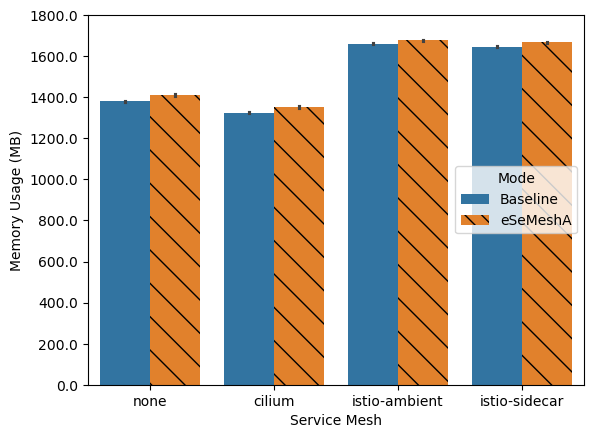

In [26]:
g = sns.barplot(data=memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Memory Usage (MB)',
    yticklabels=[format_data_size(tick, 'B', 'MB') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='center right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-memory-usage.svg', bbox_inches='tight')

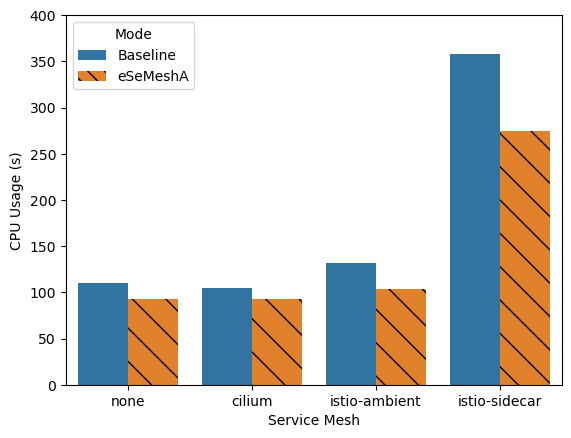

In [27]:
g = sns.barplot(data=cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')], y='value', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='CPU Usage (s)',
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-cpu-usage.svg', bbox_inches='tight')

In [28]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['RPS'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
)

summary
#print_latex(summary)

p25      p50      avg      p75
service_mesh  optimization                                    
cilium        disabled       7447.3   9803.7   9685.2  12055.0
              enabled       10275.5  13541.5  13058.0  16422.5
istio-ambient disabled       6303.4   8196.4   8172.3  10124.0
              enabled       10385.2  13808.1  13274.4  16728.0
istio-sidecar disabled       1625.3   2017.9   2049.1   2459.8
              enabled        2781.4   3479.5   3502.1   4235.2
none          disabled       6338.0   8238.7   8186.1  10240.6
              enabled       10260.2  13600.8  13104.6  16514.2

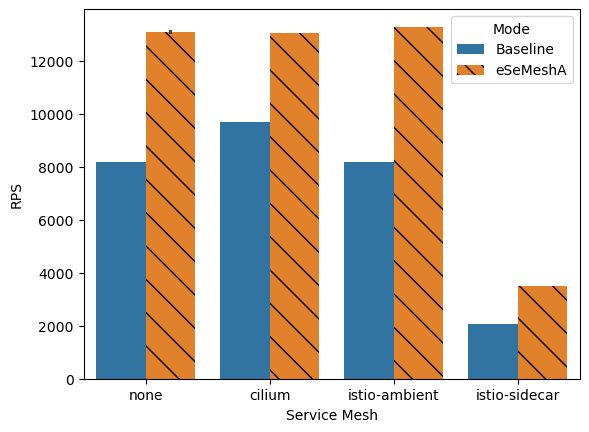

In [29]:
g = sns.barplot(data=ping_echo, y='RPS', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set(
    xlabel='Service Mesh',
    ylabel='RPS',
)

g.legend(title='Mode', loc='upper right')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-rps.svg', bbox_inches='tight')

In [30]:
summary = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))

summary
#print_latex(summary)

p25    p50    avg    p75
service_mesh  optimization                            
cilium        disabled       83.0  102.0  118.5  134.3
              enabled        60.9   73.8   91.4   97.3
istio-ambient disabled       98.8  122.0  140.5  158.6
              enabled        59.8   72.4   91.1   96.3
istio-sidecar disabled      406.5  495.6  551.5  615.3
              enabled       236.1  287.4  320.4  359.5
none          disabled       97.7  121.4  139.8  157.8
              enabled        60.6   73.5   91.2   97.5

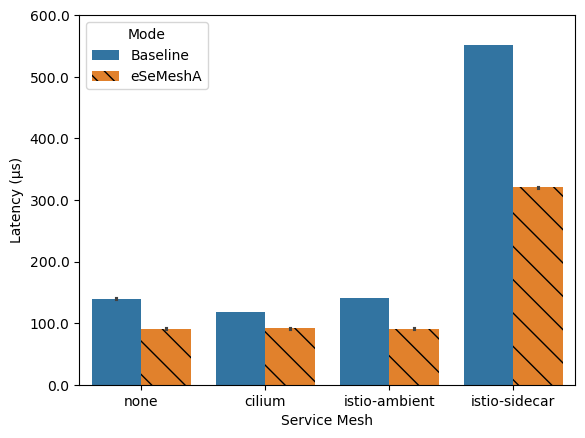

In [31]:
g = sns.barplot(data=ping_echo, y='latency', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Latency (µs)',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-latency.svg', bbox_inches='tight')

In [32]:
summary = ping_echo_extra.groupby(['service_mesh', 'optimization'])['jitter'].agg(
    p25=lambda x: x.quantile(.25),
    p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    p75=lambda x: x.quantile(.75),
).map(lambda x: format_time(x, 'ns', 'us'))

summary
#print_latex(summary)

p25    p50    avg    p75
service_mesh  optimization                            
cilium        disabled       87.6   87.9   87.9   89.2
              enabled        96.0   97.4  101.3   99.4
istio-ambient disabled       99.8  102.3  101.6  103.3
              enabled        94.7  103.9  110.9  104.5
istio-sidecar disabled      276.7  278.3  278.5  279.3
              enabled       171.8  179.1  178.8  180.0
none          disabled       95.2   96.0   96.1   96.6
              enabled        92.3   95.8   94.7   97.3

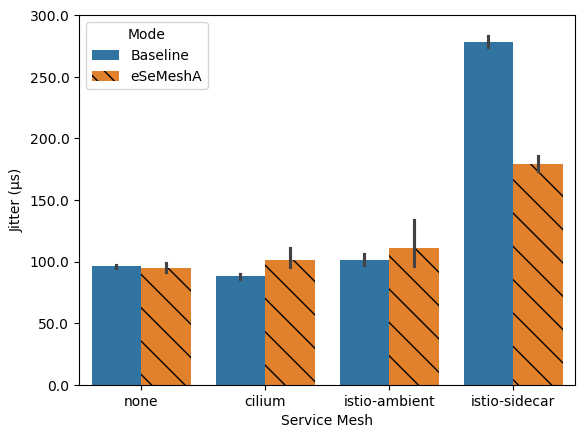

In [33]:
g = sns.barplot(data=ping_echo_extra, y='jitter', x='service_mesh', hue='optimization', order=service_mesh_order, hue_order=optimization_order)

g.set_yticks(g.get_yticks().tolist())
g.set(
    xlabel='Service Mesh',
    ylabel='Jitter (µs)',
    yticklabels=[format_time(tick, 'ns', 'us') for tick in g.get_yticks()],
)

g.legend(title='Mode', loc='upper left')
update_legend(g, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'})

hatch_patterns = ['', '\\']
for pattern, legend_patch, bars in zip(hatch_patterns, g.get_legend().get_patches(), g.containers):
    legend_patch.set_hatch(pattern * 2)
    for bar in bars:
        bar.set_hatch(pattern)

g.figure.savefig('ping-echo-barplot-jitter.svg', bbox_inches='tight')

In [34]:
summary_latency = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    #std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 'us'))
summary_latency_r = summary_latency.reset_index()

summary_jitter = ping_echo.groupby(['service_mesh', 'optimization'])['latency'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    #avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_time(x, 'ns', 'us'))
summary_jitter_r = summary_jitter.reset_index()

summary_rps = ping_echo.groupby(['service_mesh', 'optimization'])['RPS'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
)
summary_rps_r = summary_rps.reset_index()

summary_cpu = cpu_seconds_usage[cpu_seconds_usage.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    total=lambda x: x.iloc[0],
    #p75=lambda x: x.quantile(.75),
    #std=lambda x: x.std(ddof=0),
)
summary_cpu_r = summary_cpu.reset_index()

summary_memory = memory_used_bytes[memory_used_bytes.workload.eq('ping-echo')].groupby(['service_mesh', 'optimization'])['value'].agg(
    #p25=lambda x: x.quantile(.25),
    #p50=lambda x: x.quantile(.50),
    avg=lambda x: x.mean(),
    #p75=lambda x: x.quantile(.75),
    std=lambda x: x.std(ddof=0),
).map(lambda x: format_data_size(x, 'B', 'MB'))
summary_memory_r = summary_memory.reset_index()

In [35]:
def summary_format(df, metric):
    df = df.copy()
    metric_float = df[metric].astype(float)
    df[metric] = df[metric].map(float_format)
    df['p'] = (metric_float / metric_float.shift() * 100 - 100).map(float_format)
    return df.apply(lambda x: x[metric] + (f' (\\textbf{{{x.p}\\%}})' if x.optimization == 'enabled' else ''), 1)

In [36]:
summary = pd.DataFrame({
    'Latency (µs)': summary_format(summary_latency_r, 'avg'),
    'Jitter (µs)': summary_format(summary_jitter_r, 'std'),
    'RPS': summary_format(summary_rps_r, 'avg'),
    'CPU (s)': summary_format(summary_cpu_r, 'total'),
    'Memory (MB)': summary_format(summary_memory_r, 'avg'),
})

summary.index = pd.MultiIndex.from_tuples([ (a, {'disabled': 'Baseline', 'enabled': 'eSeMeshA'}[b]) for (a, b) in summary_latency.index.to_numpy()], names=['Service Mesh', 'Mode'])

summary
#print_latex(summary)

Latency (µs)               Jitter (µs)  \
Service Mesh  Mode                                                           
cilium        Baseline                     118.5                      88.0   
              eSeMeshA   91.4 (\textbf{-22.9\%})   101.7 (\textbf{15.6\%})   
istio-ambient Baseline                     140.5                     101.8   
              eSeMeshA   91.1 (\textbf{-35.2\%})   113.4 (\textbf{11.4\%})   
istio-sidecar Baseline                     551.5                     278.9   
              eSeMeshA  320.4 (\textbf{-41.9\%})  179.0 (\textbf{-35.8\%})   
none          Baseline                     139.8                      96.1   
              eSeMeshA   91.2 (\textbf{-34.8\%})    94.8 (\textbf{-1.4\%})   

                                              RPS                   CPU (s)  \
Service Mesh  Mode                                                            
cilium        Baseline                     9685.2                     104.9   
              eSeMeshA  13058.0 (\textbf{34.8\%})   92.3 (\textbf{-12.1\%})   
istio-ambient Baseline                     8172.3                     132.2   
              eSeMeshA  13274.4 (\textbf{62.4\%})  103.2 (\textbf{-21.9\%})   
istio-sidecar Baseline                     2049.1                     357.8   
              eSeMeshA   3502.1 (\textbf{70.9\%})  274.7 (\textbf{-23.2\%})   
none          Baseline                     8186.1                     110.5   
              eSeMeshA  13104.6 (\textbf{60.1\%})   92.6 (\textbf{-16.2\%})   

                                    Memory (MB)  
Service Mesh  Mode                               
cilium        Baseline                   1325.7  
              eSeMeshA  1352.4 (\textbf{2.0\%})  
istio-ambient Baseline                   1660.7  
              eSeMeshA  1677.7 (\textbf{1.0\%})  
istio-sidecar Baseline                   1645.7  
              eSeMeshA  1667.6 (\textbf{1.3\%})  
none          Baseline                   1380.2  
              eSeMeshA  1411.4 (\textbf{2.3\%})